In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:

import os
from os.path import splitext, split
import sys
sys.path.insert(0,'..')
from fibermetric import histology, utils

import nibabel as nib
import numpy as np
import time
from scipy.ndimage import gaussian_filter
import torch
from torch.nn.functional import grid_sample
import matplotlib.pyplot as plt

# 3D structure tensors from optically cleared spinal cords

In [3]:
# root = '/home/brysongray/shattuck/RodentToolsData/OpticallyClearedSpinalCords/nii2/EAE32_F1LC_Sp10x/'
# s0_path = 'TileScan_001_s0.nii.gz'
root = '/home/brysongray/data/spinal_cords/'
s0_path = 'TileScan_001_s0.subvol.nii.gz'

s0_nii = nib.load(os.path.join(root,s0_path))
affine = s0_nii.affine
header = s0_nii.header
print(affine)
print(header)

[[ 0.89099997  0.          0.          0.        ]
 [ 0.          0.89099997  0.          0.        ]
 [ 0.          0.         11.02000046  0.        ]
 [ 0.          0.          0.          1.        ]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 201 201  15   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file        : b'

In [4]:
out = '/home/brysongray/data/spinal_cords/testing/'

I = s0_nii.get_fdata()
eig_header = s0_nii.header
img_header = s0_nii.header
# dim = np.array([3, 201, 201, 201, 1, 0, 0, 0], dtype='int16')
# img_header['dim'] = dim
# eig_header['dim'] = dim
eig_header['datatype'] = 16
eig_header['bitpix'] = 32
# eig_header['pixdim'][3] = 0.8223876953125
print(f"header: {eig_header}")
print(f"affine: {affine}")
# img_patch = nib.Nifti1Image(I, affine=affine, header=img_header)
# nib.save(img_patch,os.path.join(out,'TileScan_001_s0_patch.nii.gz'))
I = torch.from_numpy(I)

header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 201 201  15   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x  

In [5]:
# nI = eig_header['dim'][1:4]
# dI = eig_header['pixdim'][1:4]
# xI = [(torch.arange(n) - n/2)*d for n, d in zip(nI,dI)]
# xI = [x.to(float) for x in xI]
# # xI_iso = [xI[0], xI[1], torch.range(start=0, end=nI[2]*dI[2], step=nI[2]*dI[2]/nI[0]) - nI[2]*dI[2]/2]
# xI_iso = [xI[0], xI[1], (torch.arange(nI[0])*nI[2]/nI[0] - nI[2]/2)*dI[2]]
# xI_iso = [x.to(float) for x in xI_iso]
# dI_iso = tuple([(x[1] - x[0]).item() for x in xI_iso])
# phi = torch.stack(torch.meshgrid(xI_iso, indexing='ij'))

# I_iso = utils.interp(xI, I[None], phi)[0]

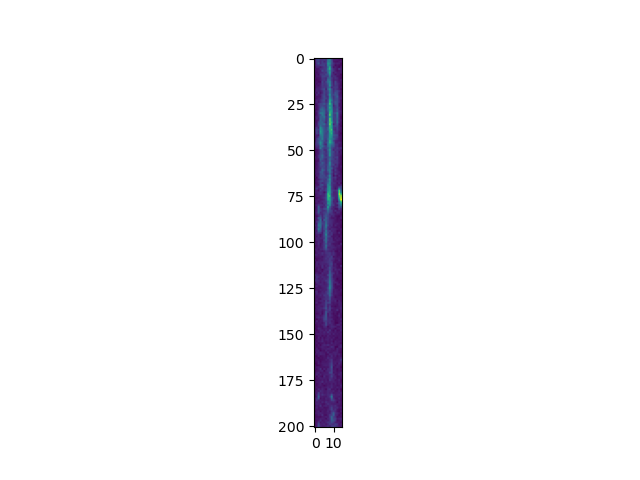

In [5]:
plt.figure()
plt.imshow(I[100,:,:])

In [36]:

# mask = np.where(patch > 20, 1, 0)
sigma1 = 1.0
sigma2 = 1.0
dI = (0.891,0.891,11.02)

S = histology.structure_tensor(I, derivative_sigma=sigma1,tensor_sigma=sigma2, dI=dI)
w,v = np.linalg.eigh(S)
w = w / np.max(w)
# w_inv = (1/w)
# w_inv_norm = w_inv / np.max(w_inv, axis=-1, keepdims=True)
# w_inv_norm = w_inv_norm.astype('float32')
# w_inv_norm = w_inv_norm * mask[...,None]
# w_inv = w_inv.astype('float32')
w = w.astype('float32')
v = v.astype('float32')
# S_eig = {"v0_z":v[...,0,0], "v1_z":v[...,0,1], "v2_z":v[...,0,2], "v0_y":v[...,1,0], "v1_y":v[...,1,1], "v2_y":v[...,1,2],
#         "v0_x":v[...,2,0], "v1_x":v[...,2,1], "v2_x":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2],
#         "w0_inv":w_inv[...,0], "w1_inv":w_inv[...,1], "w2_inv":w_inv[...,2],
#         "w0_inv_norm":w_inv_norm[...,0], "w1_inv_norm":w_inv_norm[...,1], "w2_inv_norm":w_inv_norm[...,2]}
S_eig = {"v0_x":v[...,0,0], "v1_x":v[...,0,1], "v2_x":v[...,0,2], "v0_y":v[...,1,0], "v1_y":v[...,1,1], "v2_y":v[...,1,2],
        "v0_z":v[...,2,0], "v1_z":v[...,2,1], "v2_z":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2]}

out = '/home/brysongray/data/spinal_cords/testing/'
for label,vol in S_eig.items():
    img = nib.Nifti1Image(vol, affine, eig_header)
    fbase = splitext(splitext(s0_path)[0])[0]
    new_fname = fbase + '.' + label + '.nii.gz'
    out_file = os.path.join(out, fbase, new_fname)
    if not os.path.exists(split(out_file)[0]):
        os.makedirs(split(out_file)[0])
    nib.save(img, out_file)
    print(f'saved {out_file}')

saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v0_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v1_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v2_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v0_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v1_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v2_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v0_z.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v1_z.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0.subvol/TileScan_001_s0.subvol.v2_z.nii.gz
saved /home/brysongray/data/spinal_co

In [95]:
print(S[...,0,0].min(), S[...,0,0].max())
print(I.shape)

1.0 1.0
torch.Size([201, 201, 15])


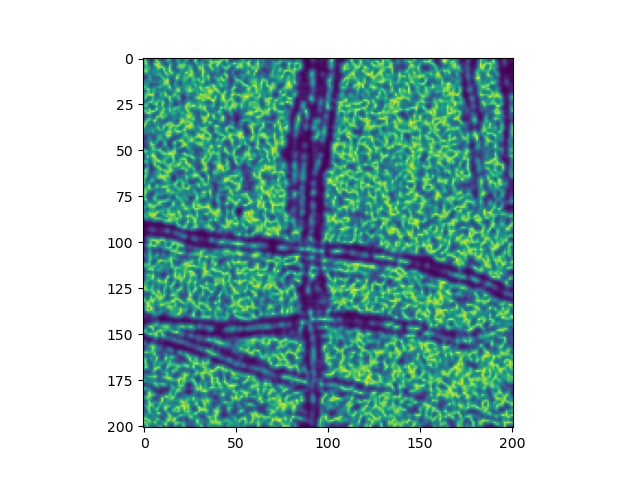

In [37]:
x = 3
anisotropy = histology.anisotropy(w=w[...,1:])
plt.figure()
plt.imshow(anisotropy[...,x])
# toshow = anisotropy[...,3].T
# plt.imshow(toshow[:,::-1], origin='lower')

In [12]:
print('x',v[...,x,0,1].min(), v[...,x,0,1].max())
print('y',v[...,x,1,1].min(), v[...,x,1,1].max())
print('z',v[...,x,2,1].min(), v[...,x,2,1].max())

x -0.015698185 0.0056175455
y -1.0 1.0
z -1.0 1.0


In [18]:
norm = np.sqrt(v[...,x,1,2]**2 + v[...,x,2,2]**2)
v_inplane_norm = np.stack((v[...,x,1,2]/norm, v[...,x,2,2]/norm), axis=-1)

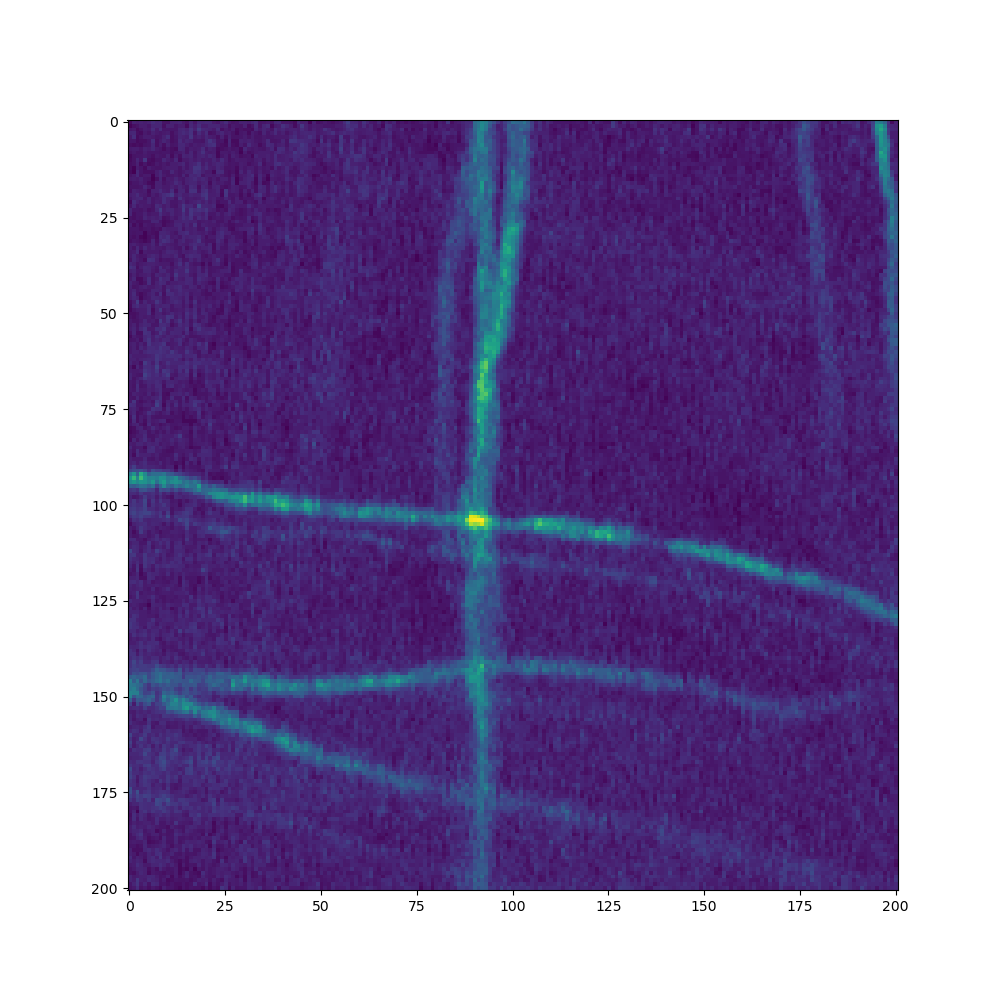

In [35]:
plt.figure(figsize=(10,10))
# plt.quiver(v[...,3,1,2]*anisotropy[...,3],v[...,3,2,2]*anisotropy[...,3], width=0.0005,headlength=0.0, headwidth=0.0, headaxislength=0.0, pivot='mid')
# plt.quiver(v[...,x,1,2],v[...,x,2,2], width=0.0005,headlength=0.0, headwidth=0.0, headaxislength=0.0, pivot='mid')
plt.quiver(v_inplane_norm[...,0],v_inplane_norm[...,1], width=0.0005,headlength=0.0, headwidth=0.0, headaxislength=0.0, pivot='mid')

plt.imshow(I[...,x])

In [18]:
print('max', v[...,3,0,2].max(), 'min', v[...,3,0,2].min())
print('max', v[...,3,1,2].max(), 'min', v[...,3,1,2].min())
print('max', v[...,3,2,2].max(), 'min', v[...,3,2,2].min())

max 1.0 min -1.0
max 0.0053064013 min -0.0040269643
max 0.0036557917 min -0.015814735


In [ ]:
out = '/home/brysongray/data/spinal_cords/structure_tensors/'
sigma1 = 1
sigma2 = 1.5
for i,file in enumerate(sorted(os.listdir(root))):
    start = time.time()
    nii = nib.load(os.path.join(root,file))
    I = nii.get_fdata()
    S = histology.structure_tensor(I, derivative_sigma=sigma1, tensor_sigma=sigma2, dI=(0.891,0.891,11.02))
    w,v = np.linalg.eigh(S)
    w = (1/w)
    w = w / np.max(w, axis=-1, keepdims=True)
    w = w.astype('float32')
    v = v.astype('float32')
    S_eig = {"v0_z":v[...,0,0], "v1_z":v[...,0,1], "v2_z":v[...,0,2], "v0_y":v[...,1,0], "v1_y":v[...,1,1], "v2_y":v[...,1,2],
        "v0_x":v[...,2,0], "v1_x":v[...,2,1], "v2_x":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2],
        "w0_inv":w_inv[...,0], "w1_inv":w_inv[...,1], "w2_inv":w_inv[...,2],
        "w0_inv_norm":w_inv_norm[...,0], "w1_inv_norm":w_inv_norm[...,1], "w2_inv_norm":w_inv_norm[...,2]}
    for label,vol in S_eig.items():
        img = nib.Nifti1Image(vol, affine, eig_header)
        fbase = splitext(splitext(file)[0])[0]
        new_fname = fbase + '.' + label + '.nii.gz'
        out_file = os.path.join(out, fbase, new_fname)
        if not os.path.exists(split(out_file)[0]):
            os.makedirs(split(out_file)[0])
        nib.save(img, out_file)
        print(f'saved {out_file}')
    stop = time.time()
    print(f"time elapsed: {stop-start}")
#     S_eig = np.stack((v[...,0,0], v[...,0,1], v[...,0,2], v[...,1,0], v[...,1,1], v[...,1,2],
#                  v[...,2,0], v[...,2,1], v[...,2,2], w[...,0], w[...,1], w[...,2]), axis=-1)
#     img = nib.Nifti1Image(S_eig, affine, new_header)
#     fname = os.path.splitext(os.path.splitext(file)[0])[0]
#     nib.save(img, os.path.join(out, fname + '_sta.eig.nii'))
#     print(fname+'_sta.eig.nii')